In [12]:
import pandas as pd
import numpy as np
import glob
from IPython.display import clear_output, display
from pymol import cmd
from IPython.display import Image

In [2]:
def clean_column_ids(df, col):
    return df[col].map(lambda x: x.split("|")[1])

def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

In [3]:
def read_fasta(path):
    db_fasta = ""
    with open(path, "r") as f:
        db_fasta = ("\n" + f.read()).split("\n>")[1:]
    a = []
    for protein_fasta in db_fasta:
        id, seq = parse_fasta(protein_fasta)
        id = id.split("|")[1]
        a.append((id, seq, len(seq)))
    return pd.DataFrame(a, columns=["seq", "str", "seqlen"]).set_index("seq").rename_axis(index=None)

def read_family(path, drop_duplicates=True):
    df = None
    try:
        df = pd.read_csv(path, delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6,17], header=None)
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=["family", "seq", "f_eval", "f_score", "f_bias", "n_dom"])
    df.columns = ["family", "seq", "f_eval", "f_score", "f_bias", "n_dom"]
    df["seq"] = clean_column_ids(df, "seq")
    if drop_duplicates:
        df.sort_values(by="f_score", inplace=True, ascending=False)
        df.drop_duplicates(subset=["seq"], keep="first", inplace=True)
    df.set_index("seq", inplace=True)
    return df

In [138]:
def get_fams(df):
    ids = df[~df.index.duplicated(keep="first")].index
    seq_fams = {}
    fam_seqs = {}
    for id in ids:
        val = df.loc[id]["family"]
        if type(val) == str:
            if not val in fam_seqs.keys():
                fam_seqs[val] = []
            fam_seqs[val].append(id)
            seq_fams[id] = [val]
        else:
            fams = val.to_numpy().tolist()
            seq_fams[id] = fams
            for fam in fams:
                if not fam in fam_seqs.keys():
                    fam_seqs[fam] = []
                fam_seqs[fam].append(id)
    return (seq_fams, fam_seqs)

def cluster_domains(seq_fams, fam_seqs):
    edges = []
    for fam in fam_seqs.keys():
        for seq1 in fam_seqs[fam]:
            for seq2 in fam_seqs[fam]:
                if seq1 != seq2:
                    edges.append((seq1, seq2))

    # for seq1 in seq_fams.keys():
    #     for fam in seq_fams[seq1]:
    #         for seq2 in fam_seqs[fam]:
    #             if seq1 != seq2 and (seq2, seq1) not in edges:
    #                 edges.append((seq1, seq2))
    return edges

# md_clusters = find_multidomain_clusters("./../out/soybean.30.multi-step/hmmscan/cluster_*.out")
# len(md_clusters)

In [5]:
class UnionFind:
    def __init__(self):
        self.parent = {}
        self.num_sets = 0

    def make_set(self, element):
        if not element in self.parent.values():
            self.parent[element] = None
            self.num_sets += 1
            return True
        return False

    def find_set(self, element):
        assert element in self.parent.keys(), "Element not found in parent"
        e = element
        while(self.parent[e] != None):
            e = self.parent[e]
        return e
    
    def union(self, element1, element2):
        x = self.find_set(element1)
        y = self.find_set(element2)
        if x != y:
            self.parent[y] = x
            self.num_sets -= 1


def solve(edges, nodes):
    sets = UnionFind()
    for node in nodes:
        sets.make_set(node)
    for (n1, n2) in edges:
        sets.union(n1, n2)
    return sets

In [141]:
def find_multidomain_clusters(path):
    fam_files = sorted(glob.glob(path))
    md_clusters = {}
    i = 1.0
    for file in fam_files:
        df = read_family(file, drop_duplicates=False)
        fn = file.split("/")[-1]
        display(f"{i/len(fam_files)*100:.2f}% : {fn}")
        sf, fs = get_fams(df)
        # print("1")
        edges = cluster_domains(sf, fs)
        nodes = list(sf.keys())
        # print("2")
        s = solve(edges, nodes)
        clear_output(wait=True)
        i+=1
        if s.num_sets > 1:
            md_clusters[fn] = df

    return md_clusters

In [142]:
mds = find_multidomain_clusters("./../out/soybean.30.multi-step/hmmscan/*.out")

'100.00% : cluster_999.out'

In [143]:
print(len(mds))
print(mds.keys())
mds["cluster_1079.out"]

6
dict_keys(['cluster_1079.out', 'cluster_1427.out', 'cluster_1506.out', 'cluster_2699.out', 'cluster_3383.out', 'cluster_605.out'])


,family,f_eval,f_score,f_bias,n_dom
seq,,,,,
I1KY15,Acyltransferase,1.300000e-11,44.6,0.0,1
A0A0R0FCN2,HAD,6.400000e-23,82.3,0.0,1
A0A0R0KQF9,HAD,6.700000e-20,72.4,0.0,1
I1JK69,HAD,2.900000e-22,80.1,0.0,1
I1JJ43,Acyltransferase,8.000000e-11,42.0,0.0,1
I1N0X0,Acyltransferase,4.400000e-11,42.8,0.0,1
I1LAF4,HAD,1.300000e-22,81.2,0.0,1
I1KKB5,HAD,7.800000e-23,82.0,0.0,1
I1J788,HAD,2.600000e-21,77.0,0.0,1


In [124]:
cmd.delete("all")
cmd.load("../data/alphafold/soybean/AF-I1JK69-F1-model_v1.cif")
cmd.load("../data/alphafold/soybean/AF-A0A0R0FCN2-F1-model_v1.cif")
cmd.load("../data/alphafold/soybean/AF-A0A0R0KQF9-F1-model_v1.cif")
cmd.load("../data/alphafold/soybean/AF-I1LAF4-F1-model_v1.cif")
cmd.alignto("AF-I1LAF4-F1-model_v1", quiet=0)
cmd.orient()
cmd.save("HAD.pdb")
cmd.save("HAD.cif")
cmd.png("HAD.png", 1920, 1080, 1200, 1)


 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
AF-I1JK69-F1-model_v1 RMSD =    1.577 (488 atoms)
AF-A0A0R0FCN2-F1-model_v1 RMSD =    1.458 (488 atoms)
AF-A0A0R0KQF9-F1-model_v1 RMSD =    1.504 (488 atoms)


1

In [125]:
cmd.delete("all")
cmd.load("../data/alphafold/soybean/AF-I1KY15-F1-model_v1.cif")
cmd.load("../data/alphafold/soybean/AF-I1JJ43-F1-model_v1.cif")
cmd.load("../data/alphafold/soybean/AF-I1N0X0-F1-model_v1.cif")
cmd.load("../data/alphafold/soybean/AF-I1LAF4-F1-model_v1.cif")
cmd.alignto("AF-I1N0X0-F1-model_v1", quiet=0)
cmd.orient()
cmd.save("Acyltransferase.cif")
cmd.save("Acyltransferase.pdb")
cmd.png("Acyltransferase.png", 1920, 1080, 1200, 1)

 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
AF-I1KY15-F1-model_v1 RMSD =    2.596 (520 atoms)
AF-I1JJ43-F1-model_v1 RMSD =    1.653 (496 atoms)
AF-I1LAF4-F1-model_v1 RMSD =    1.619 (480 atoms)


1

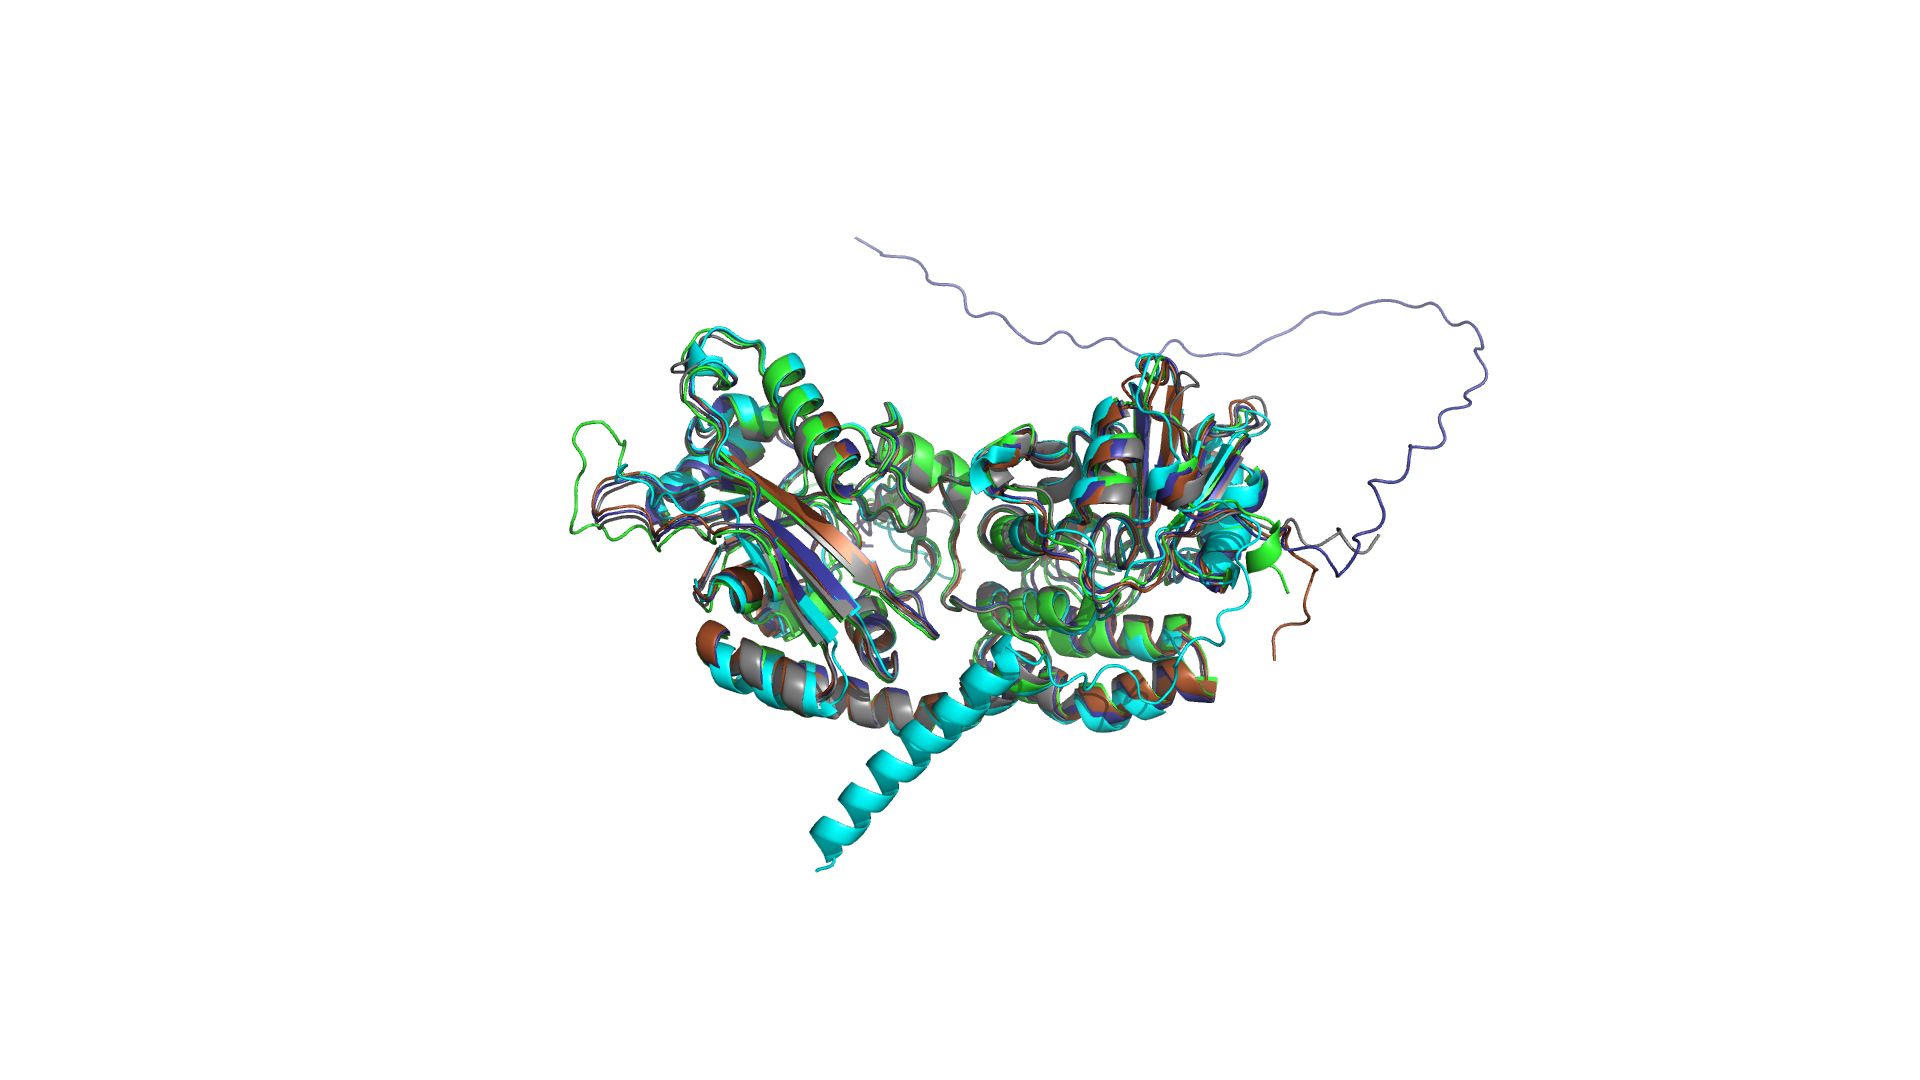

In [109]:
Image("HAD.png")

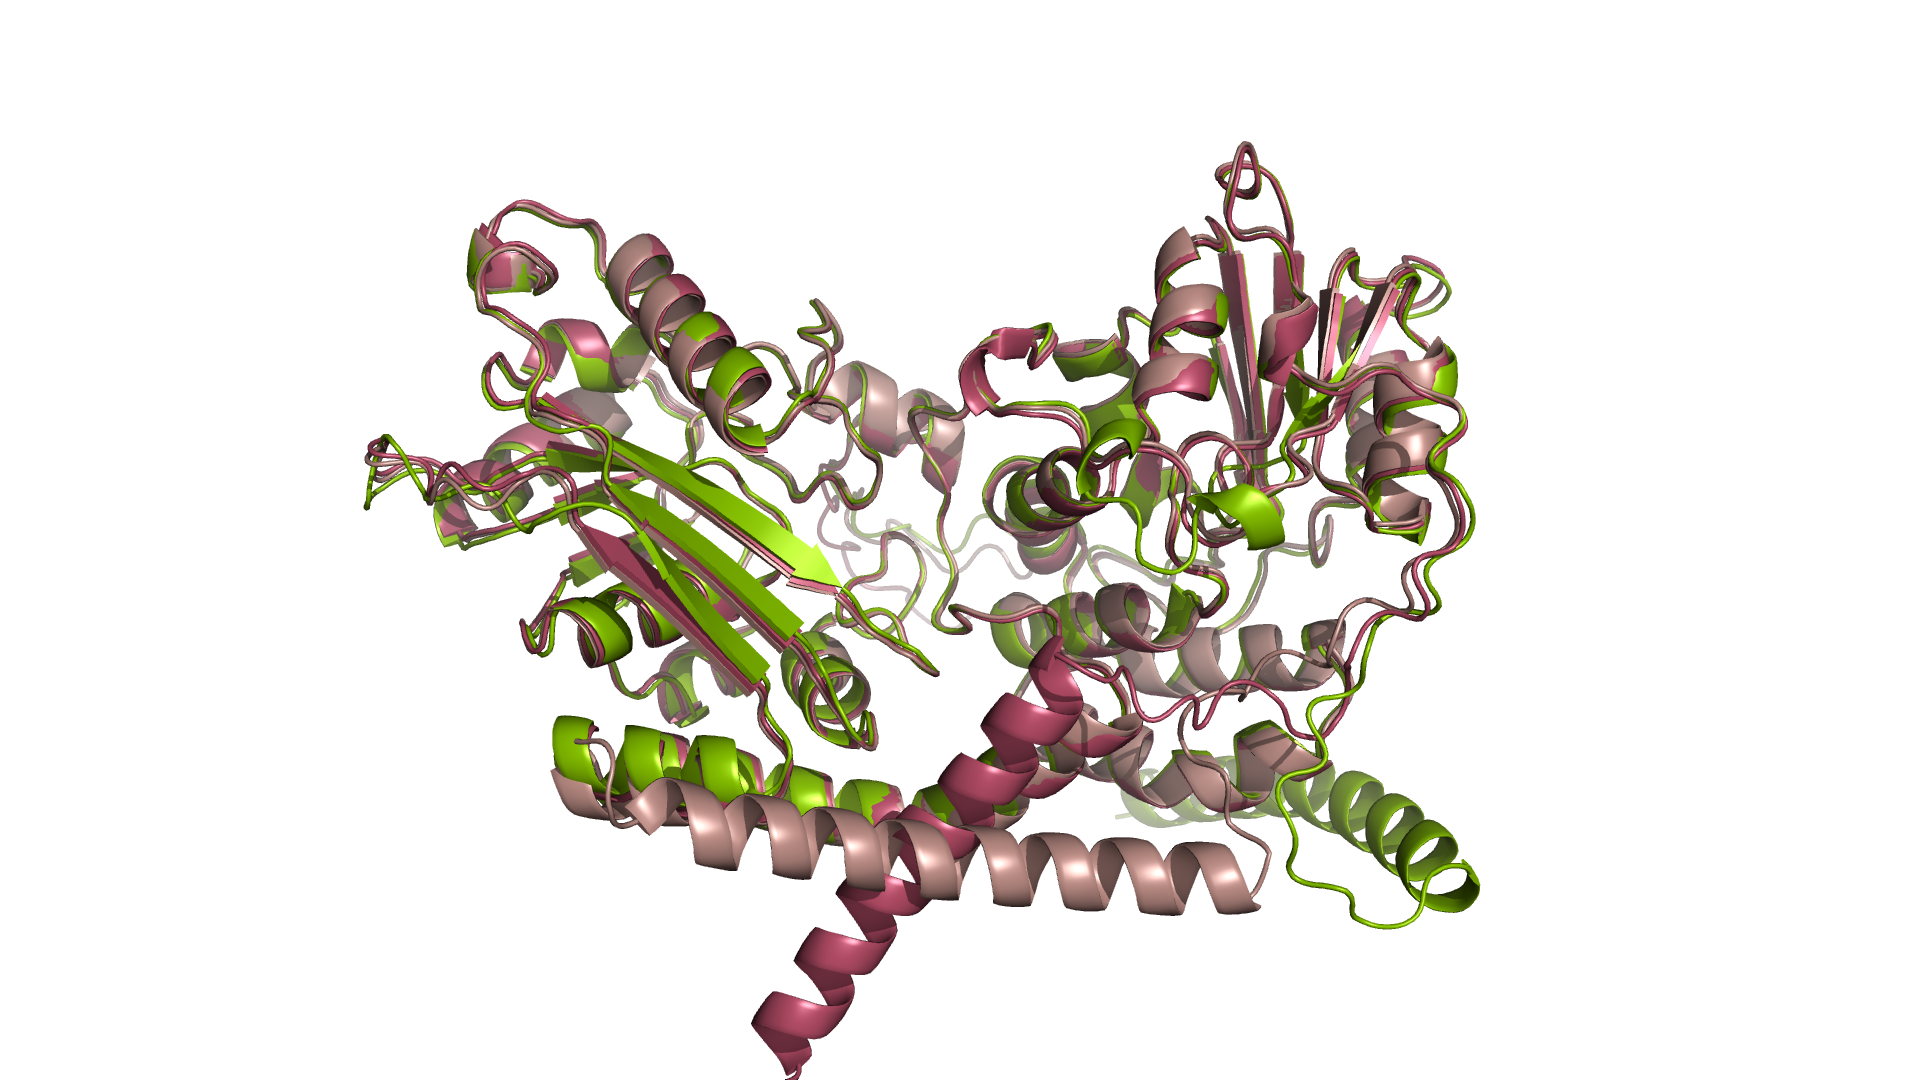

In [103]:
Image("Acyltransferase.png")

In [73]:
import nglview as nv
view = nv.show_structure_file("HAD.pdb")
view

NGLWidget()

In [74]:
view = nv.show_structure_file("Acyltransferase.pdb")
view

NGLWidget()